In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# %config InlineBackend.figure_format='retina'

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

#### Описание столбцов
1) Item_Identifier	- Unique product ID
2) Item_Weight	- Weight of product
3) Item_Fat_Content - Whether the product is low fat or not
4) Item_Visibility - The % of total display area of all products in a store allocated to the particular product
5) Item_Type - The category to which the product belongs
6) Item_MRP - Maximum Retail Price (list price) of the product
7) Outlet_Identifier - Unique store ID
8) Outlet_Establishment_Year - The year in which store was established
9) Outlet_Size - The size of the store in terms of ground area covered
10) Outlet_Location_Type - The type of city in which the store is located
11) Outlet_Type - Whether the outlet is just a grocery store or some sort of supermarket
12) Item_Outlet_Sales - Sales of the product in the particular store. This is the outcome variable to be predicted.

In [486]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


#### Exploratory Data Analysis (EDA)

In [487]:
print('Train data')
print('Amount of rows: {}; Amount of columns: {}'.format(train.shape[0], train.shape[1]))
print()
print('Test data')
print('Amount of rows: {}; Amount of columns: {}'.format(test.shape[0], test.shape[1]))

Train data
Amount of rows: 8523; Amount of columns: 12

Test data
Amount of rows: 5681; Amount of columns: 11


In [488]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [489]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [490]:
# Search missing values in data
missing_values_train = train.isnull().sum().reset_index().rename(columns={'index': 'columns',
                                                   0: 'missing_values'})
missing_values_test = test.isnull().sum().reset_index().rename(columns={'index': 'columns',
                                                                          0: 'missing_values'})

missing_values_train = missing_values_train[missing_values_train['missing_values'] != 0]
missing_values_test = missing_values_test[missing_values_test['missing_values'] != 0]

missing_values_train['percentage'] = round((missing_values_train['missing_values'] / train.shape[0]) * 100, 2)
missing_values_test['percentage'] = round((missing_values_test['missing_values'] / test.shape[0]) * 100, 2)

print('Missing values in train data:\n', missing_values_train, '\n')
print('Missing values in test data:\n', missing_values_test)

Missing values in train data:
        columns  missing_values  percentage
1  Item_Weight            1463       17.17
8  Outlet_Size            2410       28.28 

Missing values in test data:
        columns  missing_values  percentage
1  Item_Weight             976       17.18
8  Outlet_Size            1606       28.27


In [491]:
# Types of missing columns
missing_columns = list(missing_values_train['columns'])
for i in range(len(missing_columns)):
    print('{} has type {}'.format(missing_columns[i], train[missing_columns[i]].dtype))

Item_Weight has type float64
Outlet_Size has type object


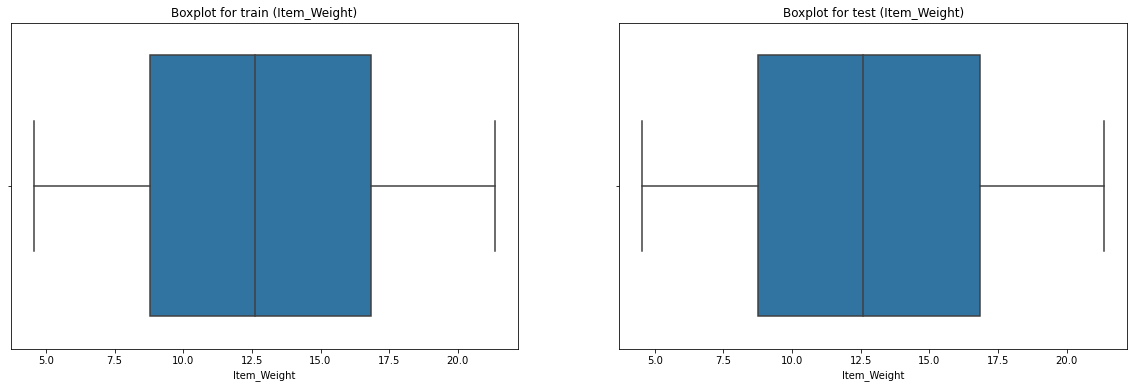

In [492]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
for i in range(2):
    if i != 1:
        sns.boxplot(train['Item_Weight'], ax=ax[i])
        ax[i].set_title('Boxplot for train ({})'.format('Item_Weight'))
    else:
        sns.boxplot(train['Item_Weight'], ax=ax[i])
        ax[i].set_title('Boxplot for test ({})'.format('Item_Weight'))

In [493]:
# Replace missing values in numeric column on median value
train['Item_Weight'] = train['Item_Weight'].fillna(train['Item_Weight'].median())
test['Item_Weight'] = test['Item_Weight'].fillna(train['Item_Weight'].median())

In [494]:
print('Freaquency of categories in train data (Item_Weight):\n', train['Outlet_Size'].value_counts(), '\n')
print('Freaquency of categories in test data (Item_Weight):\n', test['Outlet_Size'].value_counts())

Freaquency of categories in train data (Item_Weight):
 Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64 

Freaquency of categories in test data (Item_Weight):
 Medium    1862
Small     1592
High       621
Name: Outlet_Size, dtype: int64


In [495]:
# Replace missing values in categorical column on the most frequent value
train['Outlet_Size'] = train['Outlet_Size'].fillna(train['Outlet_Size'].value_counts().index[0])
test['Outlet_Size'] = test['Outlet_Size'].fillna(train['Outlet_Size'].value_counts().index[0])

In [496]:
# Count missing values
print('Missing values in train data =', train.isnull().sum().sum())
print('Missing values in test data =', test.isnull().sum().sum())

Missing values in train data = 0
Missing values in test data = 0


In [497]:
# Visualization distribution of continuous features
cont_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']

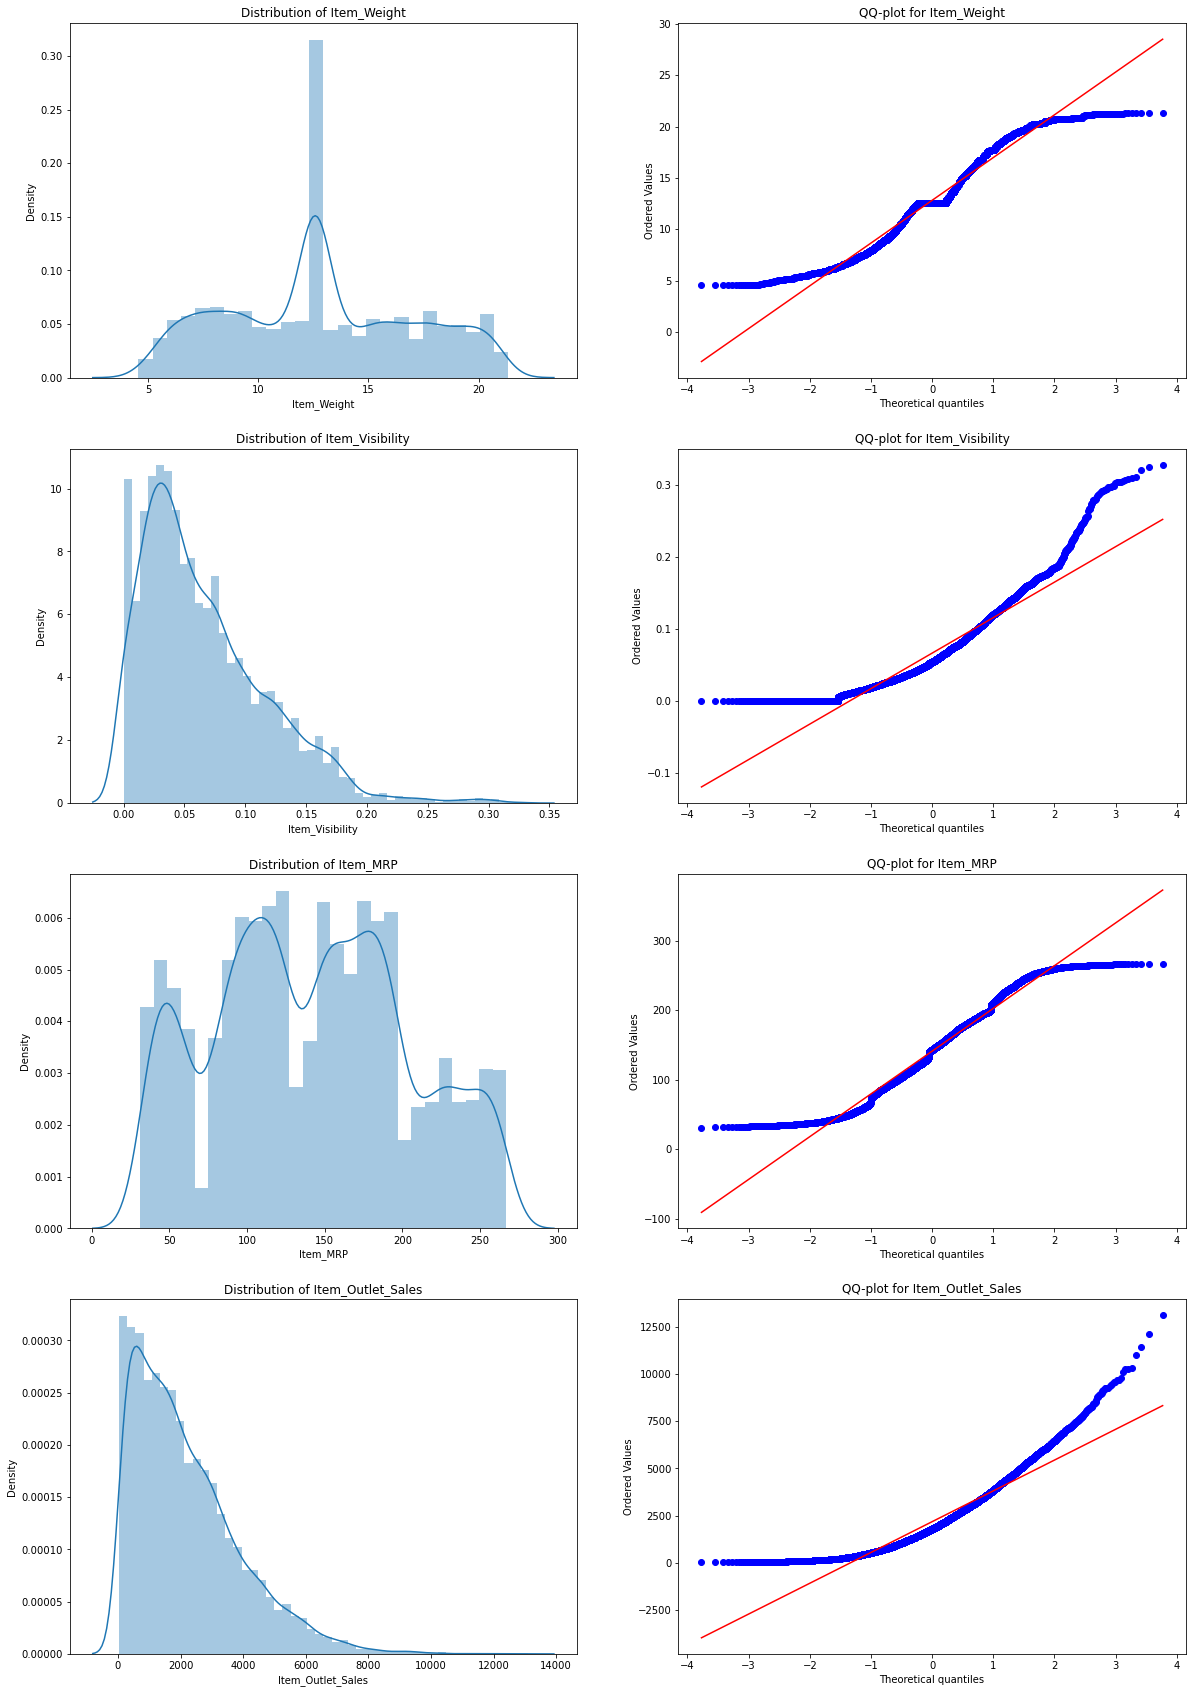

In [498]:
from scipy.stats import probplot
fig, ax = plt.subplots(4, 2, figsize=(20, 30))
for i in range(4):
    for j in range(2):
        if j == 0:
            sns.distplot(train[cont_features[i]], ax=ax[i][j])
            ax[i][j].set_title('Distribution of {}'.format(cont_features[i]))
        else:
            probplot(train[cont_features[i]], plot=ax[i][j])
            ax[i][j].set_title('QQ-plot for {}'.format(cont_features[i]))

In [499]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


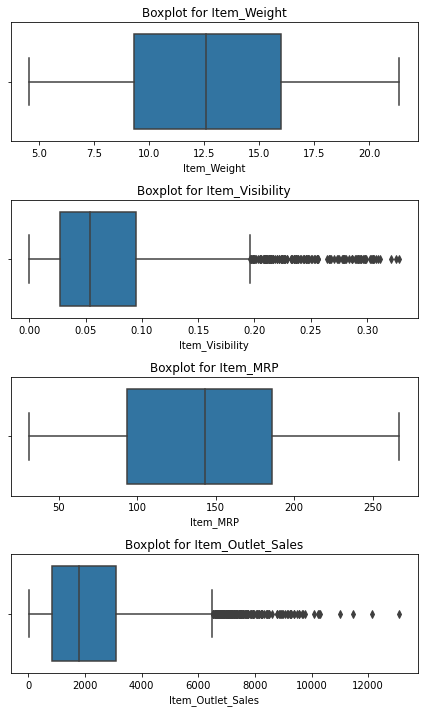

In [500]:
fig, ax = plt.subplots(4, 1, figsize=(6, 10))
for i in range(4):
    sns.boxplot(train[cont_features[i]], ax=ax[i])
    ax[i].set_title('Boxplot for {}'.format(cont_features[i]))
plt.tight_layout()

In [501]:
# We can see outliers in Item_Visibility and Item_Outlet_Sales columns.
# Remove this outliers for these columns
outliers_cols = ['Item_Visibility', 'Item_Outlet_Sales']
train = train[train['Item_Visibility'] < 0.2]
train = train[train['Item_Outlet_Sales'] < 6500]

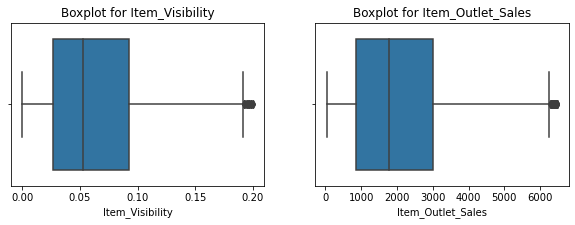

In [502]:
# Visualize boxplot for columns with outliers
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(2):
    sns.boxplot(train[outliers_cols[i]], ax=ax[i])
    ax[i].set_title('Boxplot for {}'.format(outliers_cols[i]))

In [503]:
train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [504]:
# Change incorrect categories in Item_Fat_Content on normal category: Low Fat or Regular
def change_incorrect_cat(x):
    if x == 'low fat' or x == 'LF':
        return 'Low Fat'
    elif x == 'reg':
        return 'Regular'
    else:
        return x

train['Item_Fat_Content'] = train['Item_Fat_Content'].apply(change_incorrect_cat)
test['Item_Fat_Content'] = test['Item_Fat_Content'].apply(change_incorrect_cat)

### Create visualizations of data and new features

In [505]:
def create_barplot(figsize=(10, 6), x=None, y=None, hue=None, palette='Blues', title='', xlabel='', ylabel='', axhline=None, rotation_xticks=0):
    plt.figure(figsize=figsize)
    sns.barplot(x=x, y=y, hue=hue,  palette=palette, ci=None)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axhline(axhline, linestyle='--', color='navy')
    plt.xticks(rotation=rotation_xticks)
    plt.show()

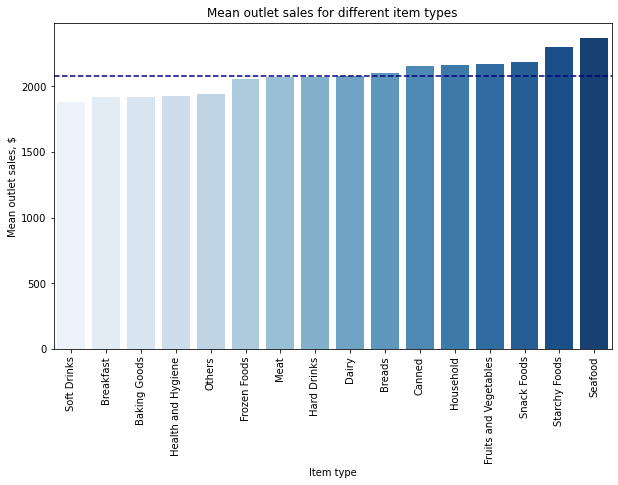

In [506]:
data1 = train.groupby('Item_Type', as_index=False).agg({'Item_Outlet_Sales': 'mean'}).sort_values(['Item_Outlet_Sales'])
create_barplot(x=data1['Item_Type'], y=data1['Item_Outlet_Sales'], title='Mean outlet sales for different item types',
               xlabel='Item type', ylabel='Mean outlet sales, $', axhline=data1['Item_Outlet_Sales'].mean(),
               rotation_xticks=90)

In [507]:
def define_item_types(x):
    if x == 'Seafood' or x == 'Starchy Foods':
        return 2
    elif x == 'Breakfast' or x == 'Soft Drinks' or x == 'Baking Goods':
        return 0
    else:
        return 1

train['max_min_sales_types'] = train['Item_Type'].apply(define_item_types)
test['max_min_sales_types'] = test['Item_Type'].apply(define_item_types)

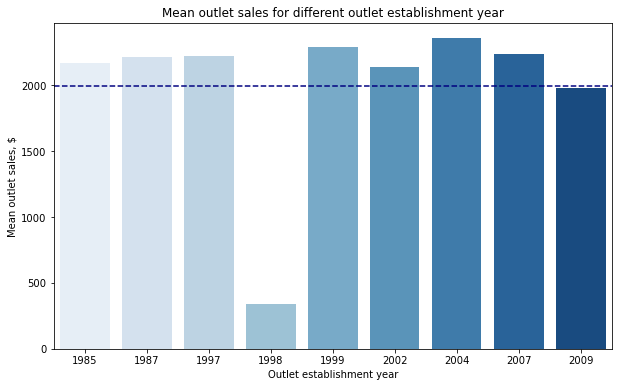

In [508]:
data2 = train.groupby('Outlet_Establishment_Year', as_index=False).agg({'Item_Outlet_Sales': 'mean'})
create_barplot(x=data2['Outlet_Establishment_Year'], y=data2['Item_Outlet_Sales'], title='Mean outlet sales for different outlet establishment year',
               xlabel='Outlet establishment year', ylabel='Mean outlet sales, $', axhline=data2['Item_Outlet_Sales'].mean())

In [509]:
train['is_1998'] = train['Outlet_Establishment_Year'].apply(lambda x: 1 if x == 1998 else 0)
test['is_1998'] = test['Outlet_Establishment_Year'].apply(lambda x: 1 if x == 1998 else 0)

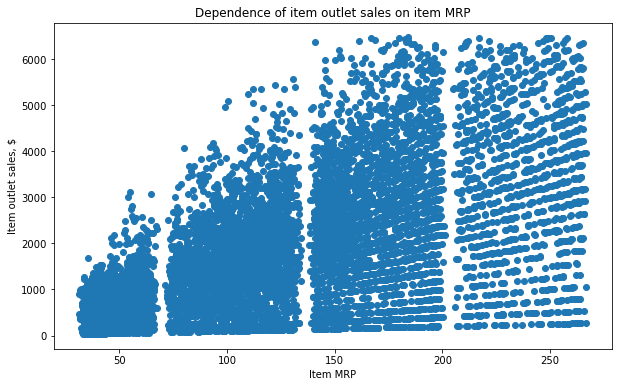

In [510]:
plt.figure(figsize=(10, 6))
plt.scatter(train['Item_MRP'], train['Item_Outlet_Sales'])
plt.title('Dependence of item outlet sales on item MRP')
plt.xlabel('Item MRP')
plt.ylabel('Item outlet sales, $')
plt.show()

In [511]:
def define_category_MRP(x):
    if x <= 100:
        return 0
    elif x > 100 and x <= 200:
        return 1
    else:
        return 2

train['category_MRP'] = train['Item_MRP'].apply(define_category_MRP)
test['category_MRP'] = test['Item_MRP'].apply(define_category_MRP)

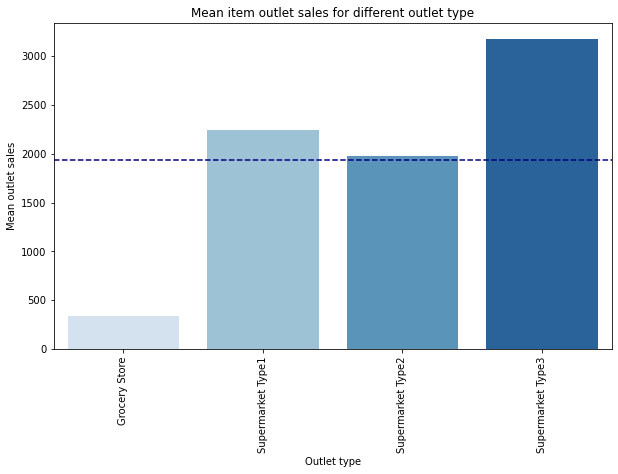

In [512]:
data3 = train.groupby('Outlet_Type', as_index=False).agg({'Item_Outlet_Sales': 'mean'})
create_barplot(x=data3['Outlet_Type'], y=data3['Item_Outlet_Sales'],
               title='Mean item outlet sales for different outlet type',
               xlabel='Outlet type', ylabel='Mean outlet sales', rotation_xticks=90,
               axhline=data3['Item_Outlet_Sales'].mean())

In [513]:
X = train.drop(columns='Item_Outlet_Sales')
y = train['Item_Outlet_Sales']
test_X = test.copy()

In [514]:
type_cols = X.dtypes.reset_index().rename(columns={'index': 'columns',
                                       0: 'type'})
obj_cols = list(type_cols[type_cols['type'] == 'object']['columns'])
obj_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [515]:
# Coding categorical features
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(X[obj_cols])
X_transformed = enc.transform(X[obj_cols])
test_X_transformed = enc.transform(test_X[obj_cols])

In [516]:
new_df_X = pd.DataFrame(data=X_transformed, columns=list(enc.feature_names_in_))
new_df_test_X = pd.DataFrame(data=test_X_transformed, columns=list(enc.feature_names_in_))

In [517]:
X = X.drop(columns=list(enc.feature_names_in_))
test_X = test_X.drop(columns=list(enc.feature_names_in_))

In [518]:
X.reset_index(drop=True, inplace=True)
new_df_X.reset_index(drop=True, inplace=True)

In [519]:
X = pd.concat([new_df_X, X], axis=1)
test_X = pd.concat([new_df_test_X, test_X], axis=1)

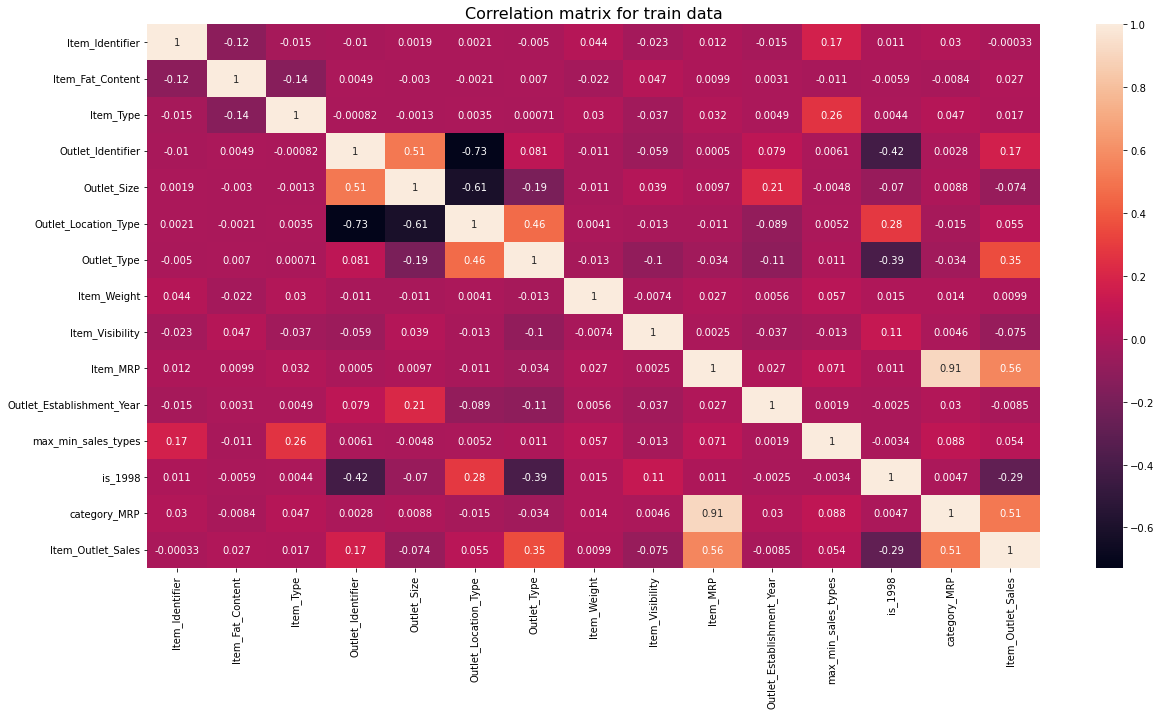

In [520]:
# Create correlation matrix
X_mat = X.reset_index(drop=True)
y_mat = y.reset_index(drop=True)
full_train_df = pd.concat([X_mat, y_mat], axis=1)
corr_mat = full_train_df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_mat, annot=True)
plt.title('Correlation matrix for train data', size=16)
plt.show()

### Create model

In [521]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [522]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

In [523]:
gbr = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100,
                                criterion='squared_error', random_state=1)
rfr = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=1)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, booster='gbtree', random_state=1)
lgbm = LGBMRegressor(boosting_type='gbdt', num_leaves=31, learning_rate=0.1,
                     n_estimators=100, random_state=1)
model_list = [gbr, rfr, xgb, lgbm]
model_names = ['GradientBoostingRegressor', 'RandomForestRegressor', 'XGBRegressor', 'LGBMRegressor']

In [531]:
gbr_params = {
    'learning_rate': [0.1, 0.3, 0.5, 0.8, 1],
    'n_estimators': [20, 30, 40, 50, 70]
}
rfr_params = {
    'n_estimators': [20, 30, 40, 50, 70]
}
xgb_params = {
    'n_estimators': [20, 30, 40, 50, 70, 80, 90],
    'learning_rate': [0.1, 0.3, 0.5, 0.8, 1]
}
lgbm_params = {
    'learning_rate': [0.1, 0.3, 0.5, 0.8, 1],
    'n_estimators': [10, 20, 30, 40, 50, 70],
    'num_leaves': [20, 25, 30, 35, 40, 50]
}
model_params = [gbr_params, rfr_params, xgb_params, lgbm_params]

In [532]:
%%time

best_model = ''
best_metric = 5000
for i in range(len(model_list)):
    print('Model: {}'.format(model_names[i]))
    model_cv = GridSearchCV(model_list[i], model_params[i])
    model_cv.fit(X_train, y_train)
    prediction = model_cv.predict(X_test)
    metric = np.sqrt(mean_squared_error(y_test, prediction))
    if metric < best_metric:
        best_metric = metric
        best_model = model_cv.best_estimator_
    print('RMSE ({}) = {}\n'.format(model_names[i], metric))
print('Best model: {}\nBest metric: {}'.format(best_model, best_metric))

Model: GradientBoostingRegressor
RMSE (GradientBoostingRegressor) = 978.4372108057944

Model: RandomForestRegressor
RMSE (RandomForestRegressor) = 1030.9432968283954

Model: XGBRegressor
RMSE (XGBRegressor) = 988.9808581487483

Model: LGBMRegressor
RMSE (LGBMRegressor) = 979.3757665251565

Best model: GradientBoostingRegressor(criterion='squared_error', n_estimators=50,
                          random_state=1)
Best metric: 978.4372108057944
CPU times: user 5min 58s, sys: 7.73 s, total: 6min 6s
Wall time: 2min 33s


### Create submission

In [533]:
sample_submission.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1000
1,FDW14,OUT017,1000
2,NCN55,OUT010,1000
3,FDQ58,OUT017,1000
4,FDY38,OUT027,1000


In [534]:
best_model.fit(X, y)
result_pred = best_model.predict(test_X)

In [535]:
data = {
    'Item_Identifier': test['Item_Identifier'],
    'Outlet_Identifier': test['Outlet_Identifier'],
    'Item_Outlet_Sales': result_pred
}
result_df = pd.DataFrame(data=data)

In [536]:
result_df.to_csv('my_submission.csv', index=False)